In [81]:
# import required packages
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [37]:
# Enter the number of rows/number of columns in the Queens board (NxN)
N = 7

In [38]:
# Manually create a region board, where a different number represents a different color region
# Compare the region matrix with the board image and you will see the number and color correspondence
# Note that number of regions/colors will be equal to N, if we had more than N colors there won't be a solution to this game
region_matrix = [ [1,1,1,1,1,1,1]
              ,[2,2,2,2,2,2,1]
              ,[3,2,2,2,2,2,1]
              ,[3,3,4,4,4,4,1]
              ,[3,3,5,6,6,4,1]
              ,[7,7,5,5,6,4,1]
              ,[7,7,5,6,6,4,1]]

region_matrix

[[1, 1, 1, 1, 1, 1, 1],
 [2, 2, 2, 2, 2, 2, 1],
 [3, 2, 2, 2, 2, 2, 1],
 [3, 3, 4, 4, 4, 4, 1],
 [3, 3, 5, 6, 6, 4, 1],
 [7, 7, 5, 5, 6, 4, 1],
 [7, 7, 5, 6, 6, 4, 1]]

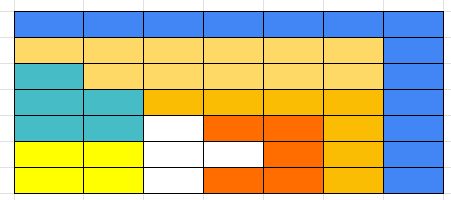

One of the final answers that I got in the game is shown below. Note that there can be more than one correct solutions (Queen positions)

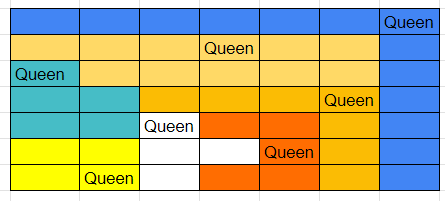

In [39]:
# Creating a dictionary where the keys are the numbers associated with colors/regions and the values are a list of the positions part of that region/color
# In this case color 7 will have the values [(5,0), (5,1), (6,0),(6,1)] as color 7 forms the box at the left bottom
region_pos_dict = {}
for i in range(1, N+1):
    region_pos_dict[i] = []


for i in range(1, N+1):
    for ind1, row in enumerate(region_matrix):
        for ind2, val in enumerate(row):
            if val == i:
                region_pos_dict[i].append((ind1,ind2))

In [67]:
# creating the initial individual (randomly) that contains the Queen positions
# For ex: for N=4, if the initial individual turns out to be [3,2,1,0]
# it means first column Queen is on the 4th row (as we count from 0), 2nd column Queen is in 3rd row and so on
# note that this is not a solution to the game, as the Queens are at each other's immediate diagonal
# also note that we are not even considering the colors in the creation of these individuals - only rows and columns are considered
# colors will only be considered while calculating the fiitness
# Another note: the way the individuals are created, you will never have two queens in the same column
def initialization(N,s=4):

    initial_solutions = []
    iter=0
    while iter < s:
        iter+=1
        solution = [random.choice(range(0,N)) for i in range(0,N)]
        initial_solutions.append(solution)
    return initial_solutions

# converts the individuals into a board so you can see how the Queens are placed
def visualize(chromosome,N):
    empty_list = []
    [empty_list.append([' ']*N) for i in range(0,N)]

    for index,elem in enumerate(chromosome):
        empty_list[elem][index]='Q'

    return empty_list

# converting the row representation of Queens to the actual board positions of the Queen
# this is same as visualize function
# this is needed so I can calculate the fitness value with respect to colors (to ensure the solution has one queen in one color region)
def convert_to_matrix(chromosome,N):
    empty_list = []
    [empty_list.append([0]*N) for i in range(0,N)]
    for index,elem in enumerate(chromosome):
        empty_list[elem][index]=1

    return empty_list

# calculating fitness for each individual (each set of Queen positions)
def fitness_val(chromosome, N, region_pos_dict):
    fitness_value = 0

    # converting the individual from its row form to its 2D board form (only needed for color fitness)
    matrix = convert_to_matrix(chromosome, N)

    # calculating row fitness and diagonal fitness
    # no need to calculate column level fitness as that is always taken care of from the initialization and subsequent individuals
    for i in range(0, N-1):
        for j in range(i+1, N):
            # checking if two Queens are adjacent to each other row wise or diagonally
            if j == i+1:
                if abs(chromosome[i] - chromosome[j]) not in [0,1]:
                    fitness_value += 1
            # checking if Queens are in the same row (but not adjacent)
            elif abs(chromosome[i] - chromosome[j]) != 0:
                  fitness_value += 1

    # region/color fitness
    for i in range(1, N+1):
        elems = region_pos_dict[i]
        sum_q = 0
        for elem in elems:
            if matrix[elem[0]][elem[1]] == 1:
                sum_q += 1
        # sum_q is 1 if there is only one queen in a row, else it is 0 (so no queen in a region, or more than one queen in a region dont get any fitness point)
        if sum_q == 1:
            fitness_value += 1

    return fitness_value

# checking if the fitness value equals the max fitness value
# max fitness value is the fitness of a solution to the Queens problem statement
def goal_check(fitness_value, max_fitness_value):
    return fitness_value == max_fitness_value

In [52]:
# sample initialization
sample = initialization(7,1)[0]
print(sample)

[3, 3, 2, 6, 2, 0, 6]


In [53]:
# visualization of that sample
visualize(sample,7)

[[' ', ' ', ' ', ' ', ' ', 'Q', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', 'Q', ' ', 'Q', ' ', ' '],
 ['Q', 'Q', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', 'Q', ' ', ' ', 'Q']]

In [41]:
# checking if fitness_val function is working correctly
# the below is the row wise representation of the solution that was shown earlier
# max fitness should be 28
sample = [2,6,4,1,5,3,0]
fitness_val(sample, N, region_pos_dict)

28

In [42]:
# this is the formula to calculate the max fitness for any value of N in Queens
# N*(N-1)/2 ensures no pair of queens are in the same row, same column or in the immediate diagonals
# + N is ensuring each color/region has only one Queen
max_fitness_value= N*(N-1)/2 + N
print(max_fitness_value)

28.0


In [66]:
def simulated_annealing(N, max_fitness_value, region_pos_dict, initial_temp, coolingfactor, beta, max_iter):
    # creating initial solution/individual
    best_fitness = []
    current_solution = initialization(N,1)[0]
    # calculating the fitness of the initial individual
    current_fitness = fitness_val(current_solution, N, region_pos_dict)
    # adding that fitness to the best fitness list
    best_fitness.append(current_fitness)

    # running it for multiple iterations
    for iter_num in range(0, max_iter - 1):
        # setting up the intial temperature
        if iter_num == 0:
            temp = initial_temp
        # updating temperature after every 'beta' number of iterations
        # using exponential decay of temperature
        elif iter_num == beta:
            temp = initial_temp*(coolingfactor**iter_num)

        # check if the goal has been reached
        if goal_check(current_fitness, max_fitness_value):
            print("Goal reached")
            res = visualize(current_solution, N)
            return res, best_fitness

        # if the goal hasn't been reached, select a random gene from the individual
        # gene refers to the queen's position in one of the columns
        k = random.choice(range(0,len(current_solution)))
        # update the randomly selected gene/queen position to another valid queen position
        new_solution = current_solution.copy()
        new_solution[k] = random.randint(0,N-1)

        # calculate the fitness of the new indiviudal
        # difference between the current individual and the new one is in one queen's position
        new_fitness = fitness_val(new_solution, N, region_pos_dict)

        # if new individual has better fitness than the current individual -> make the new individual as current individual
        # this is similar to exploitation
        if new_fitness > current_fitness:
            current_solution = new_solution.copy()
            current_fitness = new_fitness

            best_fitness.append(current_fitness)


        # if the new individual has lesser fitness than the current individual -> make the new individual as current individual with a low probability
        # this low probability is taken from Boltzmann distribution -> this helps in exploration
        elif random.random() < np.exp(-abs(new_fitness - current_fitness) / temp):
            current_solution = new_solution.copy()
            current_fitness = new_fitness

            best_fitness.append(current_fitness)

        # if the new individual has lesser fitness than the current individual -> keep the current individual as it is with a higher probability
        # this is akin to exploitation
        else:
            best_fitness.append(current_fitness)
            continue

    return 0, best_fitness

In [44]:
start = time.time()
# need to play around with initial_temp, coolingfactor and beta for different values of N
res, best_fitness = simulated_annealing(N, max_fitness_value, region_pos_dict, 1, 0.99, 100, 10000)
end = time.time()
print("Time taken (in seconds):", (end - start))

Goal reached
Time taken (in seconds): 0.057142019271850586


In [45]:
res

[[' ', ' ', ' ', ' ', ' ', ' ', 'Q'],
 [' ', ' ', ' ', 'Q', ' ', ' ', ' '],
 ['Q', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', 'Q', ' '],
 [' ', ' ', 'Q', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', 'Q', ' ', ' '],
 [' ', 'Q', ' ', ' ', ' ', ' ', ' ']]

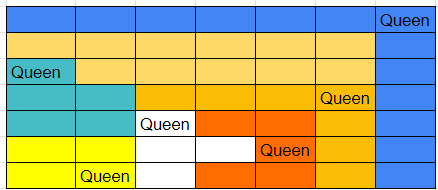

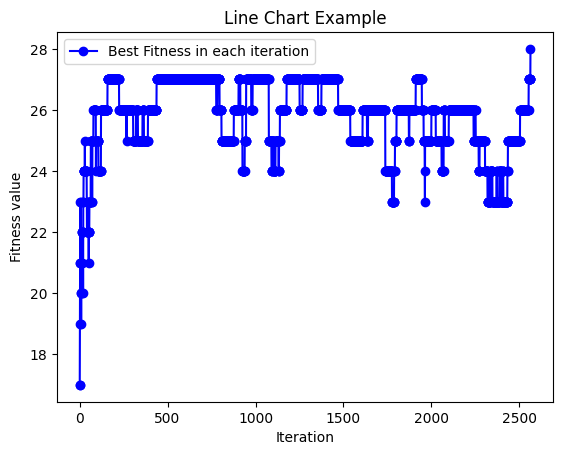

In [46]:
x_values = range(len(best_fitness))

# Create a line plot
plt.plot(x_values, best_fitness, marker='o', linestyle='-', color='b', label='Best Fitness in each iteration')

# Add title and labels
plt.title('Line Chart Example')
plt.xlabel('Iteration')
plt.ylabel('Fitness value')

# Show a legend
plt.legend()

# Display the plot
plt.show()

Checking if it works for another day's Queens

In [68]:
N = 9

In [69]:
region_matrix = [ [1,1,2,2,2,3,3,3,3]
                 ,[1,4,2,4,2,3,3,3,3]
                 ,[1,4,4,4,3,3,3,3,3]
                 ,[1,1,1,5,5,5,3,3,3]
                 ,[1,1,1,5,3,5,3,3,3]
                 ,[1,6,6,3,3,3,3,3,3]
                 ,[7,7,6,3,8,8,8,3,3]
                 ,[7,6,6,3,8,9,8,9,3]
                 ,[7,7,3,3,3,9,9,9,3]]

region_matrix

[[1, 1, 2, 2, 2, 3, 3, 3, 3],
 [1, 4, 2, 4, 2, 3, 3, 3, 3],
 [1, 4, 4, 4, 3, 3, 3, 3, 3],
 [1, 1, 1, 5, 5, 5, 3, 3, 3],
 [1, 1, 1, 5, 3, 5, 3, 3, 3],
 [1, 6, 6, 3, 3, 3, 3, 3, 3],
 [7, 7, 6, 3, 8, 8, 8, 3, 3],
 [7, 6, 6, 3, 8, 9, 8, 9, 3],
 [7, 7, 3, 3, 3, 9, 9, 9, 3]]

In [70]:
region_pos_dict = {}
for i in range(1, N+1):
    region_pos_dict[i] = []


for i in range(1, N+1):
    for ind1, row in enumerate(region_matrix):
        for ind2, val in enumerate(row):
            if val == i:
                region_pos_dict[i].append((ind1,ind2))

The above regions with its correct Queen positions are shown below

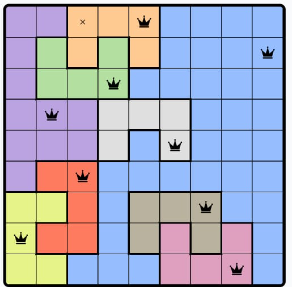

In [71]:
max_fitness_value= N*(N-1)/2 + N
print(max_fitness_value)

45.0


In [72]:
start = time.time()
res, best_fitness = simulated_annealing(N, max_fitness_value, region_pos_dict, 1, 0.99, 100, 10000)
end = time.time()
print("Time taken (in seconds):", (end - start))

Goal reached
Time taken (in seconds): 0.4313485622406006


In [73]:
res

[[' ', ' ', ' ', ' ', 'Q', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'Q'],
 [' ', ' ', ' ', 'Q', ' ', ' ', ' ', ' ', ' '],
 [' ', 'Q', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', 'Q', ' ', ' ', ' '],
 [' ', ' ', 'Q', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', 'Q', ' ', ' '],
 ['Q', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', 'Q', ' ']]

That's the same result as the one shown earlier, without the colors

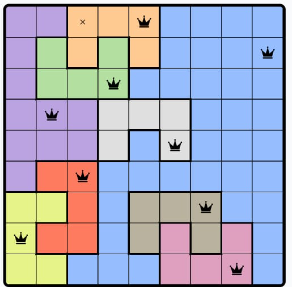

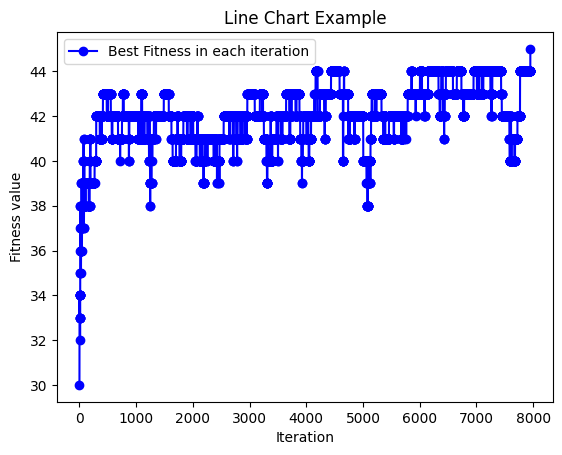

In [74]:
x_values = range(len(best_fitness))

# Create a line plot
plt.plot(x_values, best_fitness, marker='o', linestyle='-', color='b', label='Best Fitness in each iteration')

# Add title and labels
plt.title('Line Chart Example')
plt.xlabel('Iteration')
plt.ylabel('Fitness value')

# Show a legend
plt.legend()

# Display the plot
plt.show()